In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model using automap_base()
base = automap_base()
# reflect the tables with Base.prepare(), passing in the engine and reflect=True
base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found with Base.classes
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [10]:
# Create our Session() and bind it to the engine
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data

In [11]:
# Use session.query() to retrieve the date and prcp columns, .filter() by the date you calculated above, and selecting .all() results


In [12]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [13]:
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [14]:
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
   order_by(Measurement.date).all()


In [15]:
# Save the query results as a Pandas DataFrame() and set the index to the date column
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()


In [16]:
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


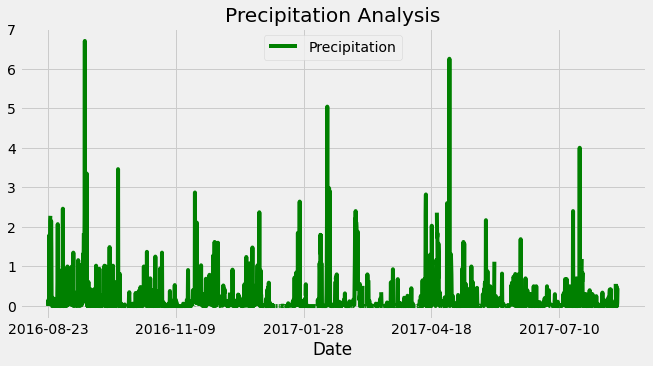

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,5), color= "green")
plt.legend(loc='upper center')
plt.savefig("Images/precipitation.png")
plt.show()

In [18]:
# Use Pandas to print the summary statistics for the precipitation data.
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
#Design a query to calculate the total number of stations.
station_count= session.query(Measurement.station).distinct().count()
station_count

9

##### Design a query to show how many stations are available in this dataset


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. Hint: session.query() the station column in the Station table
#Which station has the highest number of observations?
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp


[(54.0, 85.0, 71.66378066378067)]

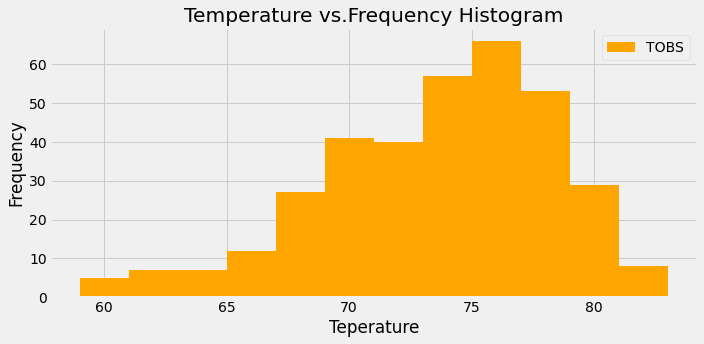

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()
# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])
# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12 , title="Temperature vs.Frequency Histogram",figsize = (10,5), color = "orange")
plt.xlabel("Teperature")
plt.legend(loc = "upper right")
plt.tight_layout()
plt.savefig("Images/temperature_vs_frequency.png")
plt.show()


## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs))
                    .filter(Measurement.date >= start_date)
                    .filter(Measurement.date <= end_date)
                    .all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-03-05', '2017-03-28')
my_trip

[(62.0, 72.06944444444444, 82.0)]

In [33]:
# Load the Results as a Pandas DataFrame
my_trip_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])
my_trip_df 

,TMIN,TAVG,TMAX
0,62.0,72.069444,82.0


In [102]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


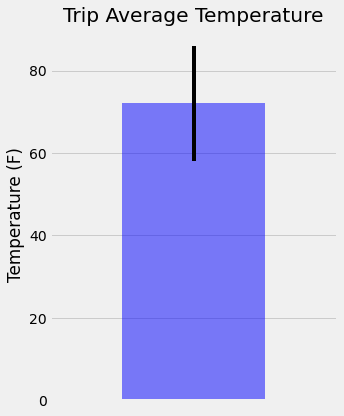

In [118]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
my_trip_df.plot.bar(y="TAVG", yerr=(my_trip_df["TMAX"] - my_trip_df["TMIN"]), 
                    title="Trip Average Temperature", color="b", 
                    alpha=0.5, figsize=(5,6), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/trip_average_temperature.png")
plt.show()
